In [110]:
import json
import pandas as pd
import requests
import re
import os
import pandas as pd
from sqlalchemy import create_engine

In [111]:
#API Call get data from NIST 
def getdata(industry):
    response = requests.get("https://services.nvd.nist.gov/rest/json/cves/1.0/?resultsPerPage=2000&keyword="+industry)
    Dictionary = response.json()
    id_ = []
    description = []
    score = []
    published_ = []
    lastModified_ = []
    dict_ = Dictionary['result']['CVE_Items']
    for element in dict_:
        id_.append(element['cve']['CVE_data_meta']['ID'])
        for i in element['cve']['description']['description_data']:
            description.append(i['value'])
        score.append(element['impact'])
        published_.append(element['publishedDate'])
        lastModified_.append(element['lastModifiedDate'])
        
    lists = [id_, description, score, published_, lastModified_]
    df = pd.DataFrame(lists).transpose()
    df.columns = ['CVE_ID', 'description','score','published_','lastModified']
    
    df = df[df.score != {}]
    df.reset_index(drop=True, inplace=True)
    df_score = df["score"].apply(pd.Series)
    df_metricV3 = df_score["baseMetricV3"].apply(pd.Series)
    df_cvssV3 = df_metricV3["cvssV3"].apply(pd.Series)
    result_df = pd.concat([df, df_cvssV3], axis=1)
    return result_df

In [112]:
# Administrative
AS = getdata('administrative service')
AS.drop(AS[AS['attackComplexity'].isnull() == True].index, inplace=True)
AS['Industry'] = 'administration'

# Accommodation and food services
#'accommodation' or 'food' or 'beverage' or 'hotel' or 'catering' or 'hospitality',
#Accom = getdata('accommodation')
Food = getdata('food')
Beverage = getdata('beverage')
Hotel = getdata('hotel')
Catering = getdata('catering')
Hospitality = getdata('hospitality')
Accom_food = pd.concat([Food, Beverage, Hotel, Catering, Hospitality], ignore_index=True, sort=True)
Accom_food.drop(Accom_food[Accom_food['attackComplexity'].isnull() == True].index, inplace=True)
Accom_food['Industry'] = 'hospitality'

#Agriculture, Forestry & Fisheries
Agri = getdata('agriculture') 
Farm = getdata('farm') 
#Fish = getdata('fisheries')
Agri_Forest_Fish = pd.concat([Agri, Farm], ignore_index=True, sort=True)
Agri_Forest_Fish.drop(Agri_Forest_Fish[Agri_Forest_Fish['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
Agri_Forest_Fish['Industry'] = 'agriculture'

#Education 
education = getdata('education') 
student = getdata('student')
uni = getdata('university')
insti = getdata('institute')
school = getdata('school')
education_industry = pd.concat([education, student, uni, insti, school], ignore_index=True, sort=True)
education_industry.drop(education_industry[education_industry['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
education_industry['Industry'] = 'education'

#'financial' or 'bank' or 'insurance' or 'finance'
financial = getdata('financial') 
bank = getdata('bank')
insurance = getdata('insurance')
finance = getdata('finance')
investment = getdata('investment')
loan = getdata('loan')
mortgage = getdata('mortgage')
wallet = getdata('wallet')
forex = getdata('forex')
treasury = getdata('treasury')
cryptocurrency = getdata('cryptocurrency')

finance_industry = pd.concat([financial, bank, uni, insurance, finance, investment, 
                              loan, mortgage, wallet, forex, treasury,cryptocurrency],
                             ignore_index=True, sort=True)
finance_industry.drop(finance_industry[finance_industry['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
finance_industry['Industry'] = 'finance'

#Government
government = getdata('government')
government.drop(government[government['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
government['Industry'] = 'government'
government

#Health & Medical
health = getdata('health')
medical = getdata('medical')
hospital = getdata('hospital')
clinic = getdata('clinic')
nurse = getdata('nursing')
patient = getdata('patient')
health_industry = pd.concat([health, medical, hospital, clinic, nurse, 
                              patient],
                             ignore_index=True, sort=True)
health_industry.drop(health_industry[health_industry['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
health_industry['Industry'] = 'healthcare'

#Rental, real estate & hiring
rental = getdata('rental')
real_es = getdata('real estate')
rental_real = pd.concat([rental, real_es],
                             ignore_index=True, sort=True)
rental_real.drop(rental_real[rental_real['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
rental_real['Industry'] = 'realestate'

#Retail Wholesale
retail = getdata('retail')
wholesale = getdata('wholesale')
supplier = getdata('supplier')
retail_wholesale = pd.concat([retail, wholesale,supplier],
                             ignore_index=True, sort=True)
retail_wholesale.drop(retail_wholesale[retail_wholesale['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
retail_wholesale['Industry'] = 'retail'

#Tourism
tourism = getdata('tourism')
travel = getdata('travel')
tour_indus = pd.concat([tourism, travel],
                             ignore_index=True, sort=True)
tour_indus.drop(tour_indus[tour_indus['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
tour_indus['Industry'] = 'tourism'

#Postal
postal = getdata('postal')
warehouse = getdata('warehouse')
airline = getdata('airline')
bus = getdata('bus booking')
ticket = getdata('bus ticket')
air_cargo = getdata('air cargo')
postal_warehouse_transport = pd.concat([postal, warehouse, airline, bus, ticket, air_cargo],
                             ignore_index=True, sort=True)
postal_warehouse_transport.drop(postal_warehouse_transport[postal_warehouse_transport['attackComplexity'].isnull() 
                                                           == True].index, inplace=True)
postal_warehouse_transport['Industry'] = 'transportation'

#Telecom
telecom = getdata('telecom')
telecom.drop(telecom[telecom['attackComplexity'].isnull() == True].index, inplace=True)
telecom['Industry'] = 'telecommunication'

#Manufacturing industry
PLM = getdata("Oracle Agile PLM")
PLM.drop(PLM[PLM['attackComplexity'].isnull() == True].index, inplace=True)
PLM['Industry'] = 'manufacturing'

In [113]:
#Concatenate all
df = pd.concat([AS, Accom_food, Agri_Forest_Fish, education_industry, finance_industry,
               government, health_industry, rental_real, retail_wholesale, tour_indus,
               postal_warehouse_transport, telecom, PLM], ignore_index=True, sort=True)
df.drop_duplicates(subset='CVE_ID', keep='first', inplace=False)
df.reset_index(drop=True, inplace=True)

In [114]:
import numpy as np
cond_list = [df['description'].str.contains('denial of service' or 'flood attack' or 'denial-of-service', case=False),
             df['description'].str.contains('buffer overflow' or ('buffer' and 'overwrite') or
             'stack overflow' or 'buffer over-read' or 'heap overflow' or 'heap-buffer-overflow' 
            or 'integer overflow' or 'heap-overflow',case=False),
             df['description'].str.contains('code execution' or 'command execution' or
             ('execute' and 'arbitrary' and ('code' or 'command')) or ('execute' and ('code' or 'command')), case=False),
             df['description'].str.contains('memory consumption issue' or ('memory' and 'corrupt'), case=False),
             df['description'].str.contains(('sql' and 'inject'), case=False),
             df['description'].str.contains('XSS' or ('cross' and 'site') or 'Cross-Site Scripting' or 'Cross-site Scripting', case=False),
             df['description'].str.contains('Directory Traversal' or 'Path traversal' or 
             ('InHand Networks InRouter 900 Industrial 4G Router before v1.0.0.r11700' and 'arbitrary') or
             ('Jenkins' and 'permission' and 'arbitrary'), case=False),
             df['description'].str.contains('Http Response Splitting' or ('request' and 'splitting'), case=False),
             df['description'].str.contains('Bypass', case=False),
             df['description'].str.contains('information disclosure' or 'gain information' or 'information exposure', case=False),
              df['description'].str.contains(('gain' and 'privilege') or 'privileged' or 'user privilege' or
              'privilege escalation' or ('unprivileged' and ('user' or 'attacker' or 'actor')), case=False),
              df['description'].str.contains('CSRF' or 'Cross-site request forgery', case=False),
              df['description'].str.contains('LFI' or ('file' and 'inclusion'), case=False)
             ]
choice_list = ['Denial of Service', 'Buffer Overflow', 'Code Execution', 'Memory Corruption', 'SQL injection', 
'XSS', 'Directory Traversal', 'Http Response Splitting', 'Bypass', 'Gain Information', 'Gain Privilege', 'CSRF', 'File Inclusion']

#df_Description['Category'] = np.select(cond_list, choice_list)

df['Denial of Service'] = np.where(cond_list[0], True, False)
df['Buffer Overflow'] = np.where(cond_list[1], True, False)
df['Code Execution'] = np.where(cond_list[2], True, False)
df['Memory Corruption'] = np.where(cond_list[3], True, False)
df['SQL Injection'] = np.where(cond_list[4], True, False)
df['XSS'] = np.where(cond_list[5], True, False)
df['Directory Traversal'] = np.where(cond_list[6], True, False)
df['Http Response Splitting'] = np.where(cond_list[7], True, False)
df['Bypass'] = np.where(cond_list[8], True, False)
df['Gain Information'] = np.where(cond_list[9], True, False)
df['Gain Privilege'] = np.where(cond_list[10], True, False)
df['CSRF'] = np.where(cond_list[11], True, False)
df['File Inclusion'] = np.where(cond_list[12], True, False)


In [115]:
#Assign Severity
df['Severity Score'] = df['baseSeverity'].map({'LOW': 1,
                                            'MEDIUM': 2,
                                            'HIGH': 3,
                                            'CRITICAL': 4})

# Insert MISP data

In [ ]:
#Database connection credentials
username = os.environ.get('MySQLroot')
password = os.environ.get('MySQLrootpw')
hostname = 'localhost'
dbname = 'securemation'

In [ ]:
#Create SQLAlchemy engine to connect to mySQL db
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
                      .format(host=hostname, db=dbname, user=username, pw=password))
dbConnection = engine.connect()

In [ ]:
MISP_cve = pd.read_sql("select * from securemation.misp_map", dbConnection);

MISP_cve = pd.read_csv('MISP_CVE-map.csv')
MISP_cve

In [118]:
def getscore(id):
    response = requests.get("https://services.nvd.nist.gov/rest/json/cve/1.0/"+ id + "?addOns=dictionaryCpes")
    #Dictionary = response.json()
    id_ = []
    description = []
    score = []
    dict_ = response.json()['result']['CVE_Items']
    for element in dict_:
        id_.append(element['cve']['CVE_data_meta']['ID'])
        for i in element['cve']['description']['description_data']:
            description.append(i['value'])
        if "baseMetricV3" in element['impact']:
            score.append(element['impact'])
        else:
            score.append({'baseMetricV3': {'cvssV3': {'version': '3.1','vectorString': 'NULL',
                                                  'attackVector': 'NULL','attackComplexity': 'NULL',
                                                  'privilegesRequired': 'NULL','userInteraction': 'NULL',
                                                  'scope': 'NULL','confidentialityImpact': 'NULL',
                                                  'integrityImpact': 'NULL','availabilityImpact': 'NULL',
                                                  'baseScore': 0,'baseSeverity': 'NULL'},
                                       'exploitabilityScore': 0,'impactScore': 0}})
        
    lists = [id_, description, score]
    df = pd.DataFrame(lists).transpose()
    df.columns = ['CVE_ID', 'description','score']
    
    df = df[df.score != {}]
    df.reset_index(drop=True, inplace=True)
    df_score = df["score"].apply(pd.Series)
    df_metricV3 = df_score["baseMetricV3"].apply(pd.Series)
    df_cvssV3 = df_metricV3["cvssV3"].apply(pd.Series)
    result_df = pd.concat([df, df_cvssV3], axis=1)
    return result_df

In [119]:
df_new = []
for i in range(len(MISP_cve)):
    df_cvssV3 = getscore(MISP_cve['CVE_ID'][i])
    df_new.append(df_cvssV3)

df_new

[          CVE_ID                                        description  \
 0  CVE-2009-3129  Microsoft Office Excel 2002 SP3, 2003 SP3, and...   
 
                                                score version vectorString  \
 0  {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1         NULL   
 
   attackVector attackComplexity privilegesRequired userInteraction scope  \
 0         NULL             NULL               NULL            NULL  NULL   
 
   confidentialityImpact integrityImpact availabilityImpact  baseScore  \
 0                  NULL            NULL               NULL          0   
 
   baseSeverity  
 0         NULL  ,
           CVE_ID                                        description  \
 0  CVE-2013-5065  NDProxy.sys in the kernel in Microsoft Windows...   
 
                                                score version vectorString  \
 0  {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1         NULL   
 
   attackVector attackComplexity privilegesRequir

In [120]:
appended_data = pd.concat(df_new)
appended_data

CVE_ID                                        description  \
0    CVE-2009-3129  Microsoft Office Excel 2002 SP3, 2003 SP3, and...   
0    CVE-2013-5065  NDProxy.sys in the kernel in Microsoft Windows...   
0    CVE-2013-3346  Adobe Reader and Acrobat 9.x before 9.5.5, 10....   
0    CVE-2012-1723  Unspecified vulnerability in the Java Runtime ...   
0    CVE-2013-2729  Integer overflow in Adobe Reader and Acrobat 9...   
..             ...                                                ...   
0    CVE-2015-4902  Unspecified vulnerability in Oracle Java SE 6u...   
0    CVE-2014-4076  Microsoft Windows Server 2003 SP2 allows local...   
0    CVE-2015-2545  Microsoft Office 2007 SP3, 2010 SP2, 2013 SP1,...   
0    CVE-2015-2545  Microsoft Office 2007 SP3, 2010 SP2, 2013 SP1,...   
0   CVE-2019-13720  Use after free in WebAudio in Google Chrome pr...   

                                                score version  \
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
..                                                ...     ...   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   
0   {'baseMetricV3': {'cvssV3': {'version': '3.1',...     3.1   

                                    vectorString attackVector  \
0                                           NULL         NULL   
0                                           NULL         NULL   
0                                           NULL         NULL   
0                                           NULL         NULL   
0                                           NULL         NULL   
..                                           ...          ...   
0                                           NULL         NULL   
0                                           NULL         NULL   
0                                           NULL         NULL   
0                                           NULL         NULL   
0   CVSS:3.1/AV:N/AC:L/PR:N/UI:R/S:U/C:H/I:H/A:H      NETWORK   

   attackComplexity privilegesRequired userInteraction      scope  \
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
..              ...                ...             ...        ...   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0              NULL               NULL            NULL       NULL   
0               LOW               NONE        REQUIRED  UNCHANGED   

   confidentialityImpact integrityImpact availabilityImpact  baseScore  \
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
..                   ...             ...                ...        ...   
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
0                   NULL            NULL               NULL        0.0   
0   

In [121]:
MISP = appended_data.reset_index(drop = True)

In [122]:
df_misp_mapped = pd.concat([MISP_cve, MISP], axis=1)
df_misp_mapped.loc[df_misp_mapped['baseSeverity'] == 'NULL']
df_misp_mapped['MISP Severity Score'] = df_misp_mapped['Threat_lvl'].map({1: 3,
                                            2: 2,
                                            3: 1,
                                            4: 0})
df_misp_mapped['misp-multiplier'] = df_misp_mapped['MISP Severity Score']* (0.01 * df_misp_mapped['Attribute_count'])
df_misp_mapped = df_misp_mapped[['CVE_ID', 'Attribute_count', 'Industry', 'description','baseSeverity','MISP Severity Score', 'misp-multiplier']]
df_misp_mapped = df_misp_mapped.reset_index(drop = True)
df_misp_mapped = df_misp_mapped.T.drop_duplicates().T
df_misp_mapped

CVE_ID Attribute_count   Industry  \
0     CVE-2009-3129              56  education   
1     CVE-2013-5065              53  education   
2     CVE-2013-3346              53  education   
3     CVE-2012-1723              53  education   
4     CVE-2013-2729              53  education   
..              ...             ...        ...   
188   CVE-2015-4902             114  utilities   
189   CVE-2014-4076             114  utilities   
190   CVE-2015-2545             142  utilities   
191   CVE-2015-2545             120  utilities   
192  CVE-2019-13720              14  utilities   

                                           description baseSeverity  \
0    Microsoft Office Excel 2002 SP3, 2003 SP3, and...         NULL   
1    NDProxy.sys in the kernel in Microsoft Windows...         NULL   
2    Adobe Reader and Acrobat 9.x before 9.5.5, 10....         NULL   
3    Unspecified vulnerability in the Java Runtime ...         NULL   
4    Integer overflow in Adobe Reader and Acrobat 9...         NULL   
..                                                 ...          ...   
188  Unspecified vulnerability in Oracle Java SE 6u...         NULL   
189  Microsoft Windows Server 2003 SP2 allows local...         NULL   
190  Microsoft Office 2007 SP3, 2010 SP2, 2013 SP1,...         NULL   
191  Microsoft Office 2007 SP3, 2010 SP2, 2013 SP1,...         NULL   
192  Use after free in WebAudio in Google Chrome pr...         HIGH   

    MISP Severity Score misp-multiplier  
0                     3            1.68  
1                     3            1.59  
2                     3            1.59  
3                     3            1.59  
4                     3            1.59  
..                  ...             ...  
188                   2            2.28  
189                   2            2.28  
190                   1            1.42  
191                   2             2.4  
192                   1            0.14  

[193 rows x 7 columns]

In [123]:
cond_list = [df_misp_mapped['description'].str.contains('denial of service' or 'flood attack' or 'denial-of-service', case=False),
             df_misp_mapped['description'].str.contains('buffer overflow' or ('buffer' and 'overwrite') or
             'stack overflow' or 'buffer over-read' or 'heap overflow' or 'heap-buffer-overflow' 
            or 'integer overflow' or 'heap-overflow',case=False),
             df_misp_mapped['description'].str.contains('code execution' or 'command execution' or
             ('execute' and 'arbitrary' and ('code' or 'command')) or ('execute' and ('code' or 'command')), case=False),
             df_misp_mapped['description'].str.contains('memory consumption issue' or ('memory' and 'corrupt'), case=False),
             df_misp_mapped['description'].str.contains(('sql' and 'inject'), case=False),
             df_misp_mapped['description'].str.contains('XSS' or ('cross' and 'site') or 'Cross-Site Scripting' or 'Cross-site Scripting', case=False),
             df_misp_mapped['description'].str.contains('Directory Traversal' or 'Path traversal' or 
             ('InHand Networks InRouter 900 Industrial 4G Router before v1.0.0.r11700' and 'arbitrary') or
             ('Jenkins' and 'permission' and 'arbitrary'), case=False),
             df_misp_mapped['description'].str.contains('Http Response Splitting' or ('request' and 'splitting'), case=False),
             df_misp_mapped['description'].str.contains('Bypass', case=False),
             df_misp_mapped['description'].str.contains('gain information' or ('information' and 'leak') or 
             'information exposure' or 'information disclosure', case=False),
              df_misp_mapped['description'].str.contains(('gain' and 'privilege') or 'privileged' or 'user privilege' or
              'privilege escalation' or ('unprivileged' and ('user' or 'attacker' or 'actor')), case=False),
              df_misp_mapped['description'].str.contains('CSRF' or 'Cross-site request forgery', case=False),
              df_misp_mapped['description'].str.contains('LFI' or ('file' and 'inclusion'), case=False)
             ]
choice_list = ['Denial of Service', 'Buffer Overflow', 'Code Execution', 'Memory Corruption', 'SQL injection', 
'XSS', 'Directory Traversal', 'Http Response Splitting', 'Bypass', 'Gain Information', 'Gain Privilege', 'CSRF', 'File Inclusion']


df_misp_mapped['Denial of Service'] = np.where(cond_list[0], True, False)
df_misp_mapped['Buffer Overflow'] = np.where(cond_list[1], True, False)
df_misp_mapped['Code Execution'] = np.where(cond_list[2], True, False)
df_misp_mapped['Memory Corruption'] = np.where(cond_list[3], True, False)
df_misp_mapped['SQL Injection'] = np.where(cond_list[4], True, False)
df_misp_mapped['XSS'] = np.where(cond_list[5], True, False)
df_misp_mapped['Directory Traversal'] = np.where(cond_list[6], True, False)
df_misp_mapped['Http Response Splitting'] = np.where(cond_list[7], True, False)
df_misp_mapped['Bypass'] = np.where(cond_list[8], True, False)
df_misp_mapped['Gain Information'] = np.where(cond_list[9], True, False)
df_misp_mapped['Gain Privilege'] = np.where(cond_list[10], True, False)
df_misp_mapped['CSRF'] = np.where(cond_list[11], True, False)
df_misp_mapped['File Inclusion'] = np.where(cond_list[12], True, False)

### Keywords for threat categories 
1. Denial of Service         
2. SQL injection             
3. Gain Privilege            
4. Buffer Overflow           
5. Bypass                    
6. XSS                       
7. Code Execution            
8. Directory Traversal       
9. CSRF                      
10. File Inclusion            
11. Http Response Splitting   
12. Gain Information          
13. Memory Corruption  

### Keywords for Categorization of Industry
1. Accommodation & food services industry - 'accommodation'; 'food'; 'beverage'; 'hotel'; 'catering'; 'hospitality'
2. Administrative and support services industry - 'administrative service'; 'support service'
3. Agriculture, Forestry and Fisheries industry - 'agriculture'; 'forestry'; 'fisheries'
4. Financial and insurance services industry - 'financial'; 'bank'; 'insurance'; 'finance'
5. Health and medical industry - 'health'; 'medical'; 'hospital'
6. Rental, hiring and real estate services industry - 'rental'; 'real estate'
7. Retail and wholesale trade industry - 'retail'; 'wholesale'
8. Tourism industry - 'tourism'
9. Transport, postal and warehousing industry - 'postal'; 'warehouse'; 'airline'
10. Government - 'government'
11. Utilities - 'Information Media'; 'Telecommunications'
12. Education industry - 'education'
13. Arts and recreation services industry
14. Building and construction industry
15. Mining and heavy industry
16. Manufacturing industry
17. Professional, scientific and technical services industry

In [124]:
import json
import requests
import re 
def getdata(threat_cat):
    response = requests.get("https://services.nvd.nist.gov/rest/json/cves/1.0/?resultsPerPage=2000&keyword="+threat_cat)
    Dictionary = response.json()
    id_ = []
    description = []
    score = []
    published_ = []
    lastModified_ = []
    dict_ = Dictionary['result']['CVE_Items']
    for element in dict_:
        id_.append(element['cve']['CVE_data_meta']['ID'])
        for i in element['cve']['description']['description_data']:
            description.append(i['value'])
        score.append(element['impact'])
        published_.append(element['publishedDate'])
        lastModified_.append(element['lastModifiedDate'])
        
    lists = [id_, description, score, published_, lastModified_]
    df = pd.DataFrame(lists).transpose()
    df.columns = ['id', 'description','score','published_','lastModified']
    
    df = df[df.score != {}]
    df.reset_index(drop=True, inplace=True)
    df_score = df["score"].apply(pd.Series)
    df_metricV3 = df_score["baseMetricV3"].apply(pd.Series)
    df_cvssV3 = df_metricV3["cvssV3"].apply(pd.Series)
    result_df = pd.concat([df, df_cvssV3], axis=1)
    return result_df

In [125]:
df_overflow = getdata('overflow')
df_overflow['Category'] = 'Overflow'

df_DOS = getdata('denial of service')
df_DOS['Category'] = 'DOS'

df_code_exec = getdata('Code Execution')
df_code_exec['Category'] = 'Code Execution'

df_memory_corruption = getdata('memory corruption')
df_memory_corruption['Category'] = 'Memory Corruption'

df_sql = getdata('SQL Injection')
df_sql['Category'] = 'SQL Injection'

df_xss = getdata('XSS')
df_xss['Category'] = 'XSS'

df_directory_tra = getdata('Directory Traversal')
df_directory_tra['Category'] = 'Directory Traversal'

df_http = getdata('Http Response Splitting')
df_http['Category'] = 'Http Response Splitting'

df_bypass = getdata('bypass')
df_bypass['Category'] = 'Bypass'

df_gain_info = getdata('gain information')
df_gain_info['Category'] = 'Gain Info'

df_gain_privi = getdata('gain privilege')
df_gain_privi['Category'] = 'Gain Privilege'

df_CSRF = getdata('CSRF')
df_CSRF['Category'] = 'CSRF'

df_FI = getdata('File Inclusion')
df_FI['Category'] = 'File Inclusion'

In [126]:
result_df = pd.concat([df_overflow, df_DOS, df_code_exec, df_memory_corruption, df_sql, df_xss, df_directory_tra,
                      df_http, df_bypass, df_gain_info, df_gain_privi, df_CSRF, df_FI], ignore_index=True, sort=False)
result_df.loc[result_df['attackComplexity'].isnull() == True]
result_df.drop(result_df[result_df['attackComplexity'].isnull() == True].index, inplace=True)
result_df = result_df.reset_index(drop=True)
result_df

id                                        description  \
0      CVE-2022-30521  The LAN-side Web-Configuration Interface has S...   
1      CVE-2022-26531  Multiple improper input validation flaws were ...   
2      CVE-2022-30789  A crafted NTFS image can cause a heap-based bu...   
3      CVE-2022-30788  A crafted NTFS image can cause a heap-based bu...   
4      CVE-2022-30786  A crafted NTFS image can cause a heap-based bu...   
...               ...                                                ...   
18860  CVE-2017-15583  The embedded web server on ABB Fox515T 1.0 dev...   
18861   CVE-2015-5069  The (1) filesystem::get_wml_location function ...   
18862   CVE-2015-5070  The (1) filesystem::get_wml_location function ...   
18863  CVE-2016-10243  TeX Live allows remote attackers to execute ar...   
18864   CVE-2015-9227  PHP remote file inclusion vulnerability in the...   

                                                   score         published_  \
0      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-06-02T14:15Z   
1      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-24T06:15Z   
2      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
3      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
4      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
...                                                  ...                ...   
18860  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-10-18T08:29Z   
18861  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-26T14:29Z   
18862  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-26T14:29Z   
18863  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-05-02T14:59Z   
18864  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-11T20:29Z   

            lastModified   0 attackComplexity attackVector availabilityImpact  \
0      2022-06-13T12:06Z NaN              LOW      NETWORK               HIGH   
1      2022-06-11T08:15Z NaN              LOW        LOCAL               HIGH   
2      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
3      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
4      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
...                  ...  ..              ...          ...                ...   
18860  2017-11-08T15:57Z NaN              LOW      NETWORK               NONE   
18861  2017-10-10T14:54Z NaN              LOW      NETWORK               NONE   
18862  2017-10-10T14:54Z NaN             HIGH      NETWORK               NONE   
18863  2017-09-19T01:36Z NaN              LOW      NETWORK               HIGH   
18864  2017-09-18T15:21Z NaN              LOW      NETWORK               HIGH   

       baseScore baseSeverity confidentialityImpact integrityImpact  \
0            9.8     CRITICAL                  HIGH            HIGH   
1            7.8         HIGH                  HIGH            HIGH   
2            6.8       MEDIUM                  HIGH            HIGH   
3            6.8       MEDIUM                  HIGH            HIGH   
4            6.8       MEDIUM                  HIGH            HIGH   
...          ...          ...                   ...             ...   
18860        6.5       MEDIUM                  HIGH            NONE   
18861        4.3       MEDIUM                   LOW            NONE   
18862        3.1          LOW                   LOW            NONE   
18863        9.8     CRITICAL                  HIGH            HIGH   
18864        7.2         HIGH                  HIGH            HIGH   

      privilegesRequired      scope userInteraction  \
0                   NONE  UNCHANGED            NONE   
1                    LOW  UNCHANGED            NONE   
2                   NONE  UNCHANGED            NONE   
3                   NONE  UNCHANGED            NONE   
4                   NONE  UNCHANGED            NONE   
.

In [127]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [128]:
def decontract(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

from nltk.corpus import stopwords
stop = stopwords.words('english')

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [129]:
result_df

id                                        description  \
0      CVE-2022-30521  The LAN-side Web-Configuration Interface has S...   
1      CVE-2022-26531  Multiple improper input validation flaws were ...   
2      CVE-2022-30789  A crafted NTFS image can cause a heap-based bu...   
3      CVE-2022-30788  A crafted NTFS image can cause a heap-based bu...   
4      CVE-2022-30786  A crafted NTFS image can cause a heap-based bu...   
...               ...                                                ...   
18860  CVE-2017-15583  The embedded web server on ABB Fox515T 1.0 dev...   
18861   CVE-2015-5069  The (1) filesystem::get_wml_location function ...   
18862   CVE-2015-5070  The (1) filesystem::get_wml_location function ...   
18863  CVE-2016-10243  TeX Live allows remote attackers to execute ar...   
18864   CVE-2015-9227  PHP remote file inclusion vulnerability in the...   

                                                   score         published_  \
0      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-06-02T14:15Z   
1      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-24T06:15Z   
2      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
3      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
4      {'baseMetricV3': {'cvssV3': {'version': '3.1',...  2022-05-26T16:15Z   
...                                                  ...                ...   
18860  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-10-18T08:29Z   
18861  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-26T14:29Z   
18862  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-26T14:29Z   
18863  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-05-02T14:59Z   
18864  {'baseMetricV3': {'cvssV3': {'version': '3.0',...  2017-09-11T20:29Z   

            lastModified   0 attackComplexity attackVector availabilityImpact  \
0      2022-06-13T12:06Z NaN              LOW      NETWORK               HIGH   
1      2022-06-11T08:15Z NaN              LOW        LOCAL               HIGH   
2      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
3      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
4      2022-06-11T03:15Z NaN              LOW     PHYSICAL               HIGH   
...                  ...  ..              ...          ...                ...   
18860  2017-11-08T15:57Z NaN              LOW      NETWORK               NONE   
18861  2017-10-10T14:54Z NaN              LOW      NETWORK               NONE   
18862  2017-10-10T14:54Z NaN             HIGH      NETWORK               NONE   
18863  2017-09-19T01:36Z NaN              LOW      NETWORK               HIGH   
18864  2017-09-18T15:21Z NaN              LOW      NETWORK               HIGH   

       baseScore baseSeverity confidentialityImpact integrityImpact  \
0            9.8     CRITICAL                  HIGH            HIGH   
1            7.8         HIGH                  HIGH            HIGH   
2            6.8       MEDIUM                  HIGH            HIGH   
3            6.8       MEDIUM                  HIGH            HIGH   
4            6.8       MEDIUM                  HIGH            HIGH   
...          ...          ...                   ...             ...   
18860        6.5       MEDIUM                  HIGH            NONE   
18861        4.3       MEDIUM                   LOW            NONE   
18862        3.1          LOW                   LOW            NONE   
18863        9.8     CRITICAL                  HIGH            HIGH   
18864        7.2         HIGH                  HIGH            HIGH   

      privilegesRequired      scope userInteraction  \
0                   NONE  UNCHANGED            NONE   
1                    LOW  UNCHANGED            NONE   
2                   NONE  UNCHANGED            NONE   
3                   NONE  UNCHANGED            NONE   
4                   NONE  UNCHANGED            NONE   
.

In [130]:
result_df['description'] = result_df['description'].str.lower()
result_df['description'] = result_df['description'].apply(decontract)
result_df['description'] = result_df['description'].apply(cleanPunc)
result_df['description'] = result_df['description'].apply(keepAlpha)
result_df['description'] = result_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
result_df['description'] = result_df['description'].apply(stemming)

In [131]:
result_df['baseSeverity'].value_counts()

HIGH        9144
MEDIUM      6139
CRITICAL    3381
LOW          201
Name: baseSeverity, dtype: int64

In [132]:
X_train, X_test, y_train, y_test = train_test_split(result_df['description'],
                                                  result_df['baseSeverity'],
                                                  stratify=result_df['baseSeverity'],
                                                  test_size=0.3, random_state=123)

In [133]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train.tolist())


print(str(tokenizer.texts_to_sequences(['about the data'])))

[[1, 1, 66]]


In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train.tolist(),\
                                                      y_train.tolist(),\
                                                      test_size=0.1,\
                                                      stratify = y_train.tolist(),\
                                                      random_state=123)

In [135]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.tolist()) )

x_train = pad_sequences(x_train, padding='post', maxlen=200)
x_valid = pad_sequences(x_valid, padding='post', maxlen=200)
x_test = pad_sequences(x_test, padding='post', maxlen=200)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(y_test.tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:11884
Class distributionCounter({'HIGH': 5760, 'MEDIUM': 3867, 'CRITICAL': 2130, 'LOW': 127})
Valid data len:1321
Class distributionCounter({'HIGH': 640, 'MEDIUM': 430, 'CRITICAL': 237, 'LOW': 14})


C:\Users\heilu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
C:\Users\heilu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
C:\Users\heilu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

[   2   58   57   73 1088  735    9    4   25   12    3  132   55   26
    3   15   27    2   60 1205    6   76    3    9   13    2  564  407
  216   15   58   57   85   13    9    4    3 2861   58   97  131   19
   79   44  100   57  767   66  564  285    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [136]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['MEDIUM', 'CRITICAL', 'MEDIUM', 'MEDIUM', 'HIGH', 'MEDIUM', 'CRITICAL', 'HIGH', 'HIGH', 'CRITICAL']
Text to number
[3 0 3 3 1 3 0 1 1 0]
Number to category
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [137]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[   2   58   57   73 1088  735    9    4   25   12    3  132   55   26
    3   15   27    2   60 1205    6   76    3    9   13    2  564  407
  216   15   58   57   85   13    9    4    3 2861   58   97  131   19
   79   44  100   57  767   66  564  285    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

tf.Tensor(
[213 793   5  65  15 190  98   2   9  30 182  17  23   3   9 201   2  49
 361 726  13  18 105   6 104 106 165  95  39  11   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   36    29     2   418  2330   498     4    12    74     3    49    70
    25   382

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[146  48  28   1 483 516  32   4  12   3 245 512  80  84  13 146  51  10
  22 127  97   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=flo

tf.Tensor(
[  55   34  116   53    2 2473    1    4   12    3  379   25   99    7
   17   34   10  239  180   45   47  129   52  767 1600  644   52  342
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  55   34  116   53    2  465  111 3082   75   65    4    3  428  390
 3082  111    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 378 1481 1202  172    5   32   16 1202    5   32   61   67  228    4
   21  133   12   25    6   52  209  128  131 1873   97   54  252   17
 1321  133   21    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 94  23  51  18 110 198  23  90  18  87 302 474  71 164 355 590 595  71
 474  71  80  39  22  58 131  52  30  17   8   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0

tf.Tensor(
[    1    37  1007     1    89   193   142 16150  5491   575     1   225
   743 17521   293     4    62     6    54   652    21   201    33  5491
   439   205     7   178   160     2    33   740    87    14     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[   6 1275    6  620  620 1195   96   75  218    4    6  594  168   70
  849   54 3919   19   60   49  197  594  327  103 1051   70 2591  223
  350  509    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 137    1  500 1473 1428    4   41   20   10  120   29   22  820   11
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

tf.Tensor(
[   2  107   50   73  426  300   35   73  426  300   35  238   35  204
 1867    9    4   74   12    3  132   55   26   40    3    6  107   50
   15   83    2   60  155   67  236   76  107   50   15   83    3    9
   13    2  254    6   50  260   22  158   85   13    9    4    3    7
   17   26    8  102   15   50   19   79  274   44    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   2   66 6391    1    1  658 1449   73 2846  144 1583   20  295    9
    4   74   12    3   31  658 1449  594    2   60  314   90  359  120
  410    1  658 1449    3    9   13    2   86   22 1166 1166  120   15
   47   85   13    9    4    3   31    1  658 1449  594   45   41   20
  113  143  406   72  658 1449    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 267   53  103    1   96   75    5  129  285    9    4    3  210 1223
   99  223  136  234    3  162    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[3151 1960    4 2186    1   59   72   10    1   38   11 2186   46   45
    7   17   46    8  505   11   10 2186    1 5265   38  312 2186   46
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 396    2   33  197 2022 2135   80  525  125 7584 2131   11   68   22
   11   63  692  771   23   45   23   51   17    8    7   63    2  106
   91   95 2024  359   11    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 94  23  51  18 110 198  23  90  18  87 302 595  71 474  71 474  71  80
  39  22  58 131  52  30  17   8   7   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Ten

tf.Tensor(
[  48   28 9150  243 4745   16    4    3   31   41   20  113   10   22
   48  440 4746   47    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[   36    29   305   324 12891 12891    32     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

tf.Tensor(
[  12    8    7  444    2   33 2863   10  131   75    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[11500     4   438   204   203    53   150     9     4    74    12     3
   132    55    34   116    53     3   117    17   157    15    27     2
    60   155    53   150   107    35    50    15    27     3     9    13
     2   254     6    50   284    39    22   158    85    13     9     4
     3   117    17   157    15    27    21     6   157   130     4     3
   564     8    25     6    45    62    11   282    25     6   149   204
 11500   438   383    39   498   438     8   204     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[  36   29    2  219   20  159 2717 1823   42    4   12   74    3  171
  389  276  194  256   20   10  161   22  309    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

tf.Tensor(
[  55   26   40    2 5851    1 5195 8021   16    4   25    3    7   17
   58   26  127   10   22  224   29  206   38    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[3794 3794   88  263  114   60   23   51    9   30   62  133   21   27
    7   21   91    6  104   91   13  101  326  140 1673   64 1984  894
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[  18   56 2111 2008  142  142  142  142  142  142  973   23   51    2
    1    4   88    3  114   87 1255   66 2438   13   18    9   30  133
   21  973    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   80   504   232  2824 14516   741  1399    11   865  5283  5284   533
   529   319  1649  1107  7506   268   395    24    45   319  1407    45
   217    48    28    30     8     7   102    57     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 55  26  40   2  33   1 312  13   3 163  79  44   6 333   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[3740    2   55   34  116   53    0    0    0    0    0    0    0    0
    0    0    

tf.Tensor(
[  18   56 6101 3564   92   43   47  365   92    1 1375  365   92    2
   12   82    7    4    3    7   17   27   82   42  199    6   21   25
   19  112   49   24 2072    8  234    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 108   76  299    2   33 5326  852   42    9   30   74 3026   29   45
   84  444    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  60 1544 1736  473   58 1470  473  307  300   35   57   52  137   30
   41   20  817 1050    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[3593   61  251   55   26   40    2   97   35  984    4    3  163  333
   10   22  224  955  336 1276    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   18    56 11651   470    23   110   258    37     1   830  1644    89
    63    86    22    11   434     4     3    31    41    20   581   801
    88   239   171   106    95    68    22    11     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  55   34  116   53    2  465   26   69   75    1   65    4    3  465
   86   77   34 1000 1453    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[4592   28    2  169  680 6140   66  549    5   43   43   43   51 6140
   24 9536   82    3    9   31  680  117   92 3268  556 1093  460    1
   48    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   1  109  871  746  285 2836   75   96   53   45   40  248    1   46
    1  435   46    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 183  577   47   15   25   49   15 2291 2383   93   93   93   93  387
   93  387    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[126  69  19  35  58   2  36  29  12   3   9  86 298  36 322   9   4   3
 261  44 308 167   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  23   51    2   33   71  543  862  108   90  124   23  109 2075  862
   23   51    

tf.Tensor(
[   1 1304   35   15  251   55   26    2   40 1213    1  456   38   10
  242   25  105    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   36    29     2  1951    10  8125 13369  1471    18     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  55   26   40    2    1    1   16    4    3    7   17   58   26  127
   10   22  733  179 1011    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[2884   16   15   36   29   70  158    1   46    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[1267  168    2   33 4800  397  686   35   37  635  699  398   68   22
   78   34   30   41   20    3   86  494   34   63    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 71  69 142 331  69 219  49   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=flo

tf.Tensor(
[   94    36    29     2   162  7074    46   162  7074    46  7671    65
     4    12     3     7    17    36    82    10   456 17821    38     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 126 1760 1003    9    4   62    3    7   17    8   27   31   23   51
  254  106   95  298   11    3    9   13    2    7   17    8   27  126
  270   64    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 59  72   2 596 857  27 646  37 344   1   4  12  25  99 114  17  11  10
 513 513 505 436 551   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[5281  250  231  214 2371   46  296   15    5 1485   27  317    3   13
    2   49   2

tf.Tensor(
[1046  731  306  925 6703  246   96   24  925   43   43   43   43   43
   43   40 1438 1235    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  13  123   28    2   33 2338  264  187   37 1885  533 2338   57   68
   22  264   31  264  375  117  926   52   28   45 3308  146  320  291
  486   66   11  320  217   48   28  258   51   23  232   23   51    4
    8    7  102   57    3 1732  106   95  264   63    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  55   26   40    2  177  277  261 1138   46    1 1875   75   96    4
   12    3   29   17  216  127   10  417   38    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 217   48   28    2   33  393 1527 5237   37 1922 1261 2146  207 5237
  225 1527 3065   11 4734  330   11   24  529   76  395   48    3  159
   39   11   63    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[3868    4   81 5192  630   41   20   10  413 4207 1442  124    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 737  725  647 1650    2   25   49   30   12    8    7   42   13 2188
 4837  211  277   65  354  211  277  354 3790  277   65  354 3790  277
  354    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[5556 5557    4  986   11  121  121   46    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[857 127 303 708 715  42 715  66 289   5   5   5   4  12   3  29  17 127
 216  10  55  26  40   2   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Ten

tf.Tensor(
[   2  169  426  150   57   16   65    4   39  657    1  454   78   19
   54   21 1670  426  150   57    2   87  426  150   57   16  291    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 750 8085  243   61    2  599 1118   35 8085   75    9    4    3  414
   44    9   30  110  777 2139 1036  726   49   15 8085    5   43   32
    5   43   32    5   43   32    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[  13  146   51    2   33    1   37 3551 2666 3019 3020   24 3733   68
   22  865   11   31  146   51   45   17    8    7    3   86  159   39
  865   11   63    2    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 7017   217    48  1727     1 11661    89     4     3    31   259    10
    22    11     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 12   8   7   2  33 197 372  26 115  90 124  23 138 269 109 372  26 115
  23  51   2  14  64 176  14  14  14  14   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 857  306   46 1890  679  984 1040 2646   75   96   59   72   10  430
   38    0    

tf.Tensor(
[ 41  20   2  33 822 429 136  82 375  37 798 799  16 298 144  77  34  30
  41  20   3  86  77  34  63   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  2 107  35  50  73 631 872  83   9   4  74  12   3 132  55  34 116  53
   3  15  27

tf.Tensor(
[  1 266 715   5   5   5   5   5   4  12   3   3   6 425 149 163   6  55
  34 116  53 252  10  95 453   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 12  25  49   2  56 405 954 337  35   5 954 337  35  43  32 954 337  35
  43  32 804

tf.Tensor(
[ 892  468  563  964  303   23  988  218  484  325  325  684  218  721
 1052   23   51 1049  765 1019    9   13  119   17    8    2   15  325
  789  325  684    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[2423   15  191  118   26   40    2   13    2 1589  165 1094   39  722
   11    2    4   25    3   29   39    8  119  151  838   58   97  383
    6  100   40    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  41   20    2   33 1264  111   37 3217   27  435 3218  826   16  298
   78  120   30   41   20    3   86   39  120   63    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 547  349  613    5   43   65   43   65   43   65   15  190   98    2
  187   22   11    9   45   98 1093  460  320   23  549    3    9  201
    2   49  361  726   13   18  105    6  104  106  165   95   39   11
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[1214 1187  812    5  616   23   51    2 1897  916    1   80   25   12
    3   31   41   20  415  304  455  160  390   14   14    1    2 1897
  916    1   80 1988   14  305  542 3916  525    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  1   1  53  10 292 241  46  70  70 275 127 343   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 94   2 107  35  50  73 591  20 115 944  83   9   4   3 132  55  26  40
   3   6  50

tf.Tensor(
[   1   75   15  251   55   26   40  207 1716   38    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 29  18 110 198  67  18  87 195 457 487  69 135 401  69 135 555  39  57
  52 149  54 199  21   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[1832 3329   42  627   25   59   72    2   30   12    8    7    0    0
    0    0    

tf.Tensor(
[ 418  158   59   96   75   67  230 3222   38   24   36  322   10    1
  364  157  194   74   25    6   30   74   36   29    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[1911  420 1149   16  294 1911  420 1149   16  294 1295  420 1149   16
  294 1295  420 1149   16  294 1911  420 1149   16  294 1911  420 1149
 2505   16  420 1149 2505   16  420 1149  989 2743 2391  294 1295  420
 1149  989 2743 2391  294 1295  420 1149  989 2743 2391  294 1911  420
 1149  989 2743 2391  294 1911  420 1149  989   16  294 1295  420 1149
  989   16  294 1295  420 1149  989   16  294 1911  420 1149  989   16
  294 1911  420 1149  989   43 2743 2391  294 1295  420 1149  989   43
 2743 2391  294 1295  420 1149  989   43 2743 2391  294 1911  420 1149
  989   43 2743 2391  294 1911  420 1149  989   43   16  294 1295  420
 1149  989   43   16  294 1295  420 1149  989   43   16  294 1911  420
 1149  989   43   16  294 1911  420 1149 2250   16  294 1295  420 1149
 2250   16  294 1911  420 1149 2250   16  294 1295  420 1149 2250   16
  294 1911  420 1149 2250 2505   16

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  126    66   599   378  2961    66     9     4   237     6    49    66
  4029   663   163 17478    44   126   270    64     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     

tf.Tensor(
[ 515 1763  630    2   33  548  141    5   32   16  548  141    5   32
   16    9   31   88   41   20  114  161   23  110   92 1264    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   1   75   96   53   45   40   10  714 2516    1   46    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[    1 13227  1231    53    10    99     1    46   174     6     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 59  72  18  56 720   1 312 164 258 828 128 230 388 778 821   9  13   3
  49 653 205  62  57  11   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 183  976 1156   47   52    2   84   44  182   41   20   12    8    7
    0    0    

tf.Tensor(
[  25  237  734    6  454  100   55   26   40    2 4821  645   96   75
    5    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  18  110  198  103   18   87  195  457  487   69  135  401   69  135
  555   39   57   52  149   49 1803 1624    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  13 2130   41   20    2   33 1395  669  119  141    5  141  354   37
   63   10 1909  414  990  141  434   24 1921   77   34   47  103 2350
  141  181  899  177  540    4  908  990  141    1  769   47   61  390
 4683    1  908  268  141 1547    1   45 2130 4230  143   63    2    3
   91 1369   12   42  523 1395  542 1159  990  141  181    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 418 1668 1508  588   27    2   36   29   10    1  241   46    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[ 36  29   2   1  10 733  38   1  46   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   1 1062   15  251   40    2  545  336  219    0    0    0    0    0
    0    0    

tf.Tensor(
[  18   56 2552 3311 2059   47   47  159   26   11  225 2340 1109    4
    6  414   11  100    1  497   47  464  430   38   67  623    4    3
   59   72  475    1  497   98   11   47 2214  175  497    1   47    7
    3  459   74 3695    7   59   72    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 4966  1054   144   255   101  6218   255     1   255     1   255     1
   255     1   255     1   255     1     1   255 14595   255   255     1
   255     1   255 14595   255     1   255     1    16    56    61   134
    48    28    11   569 15667  1518     2     4     3    31    41    20
   113    10    22    28    66     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 779   69    5   43   32   43   32   43   32   43   32  917  259  113
    3   10  480  237   34 1537  151   58 4370   57   39    6    3   86
   94   34  480  237   34  237    8  481   84 1186   27  266   24 1060
  238   94  238    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 134   48   28 3983  483  516   32    4   12    3   84   13  134   51
   10   22  127   97    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  48   28    2 2322  671  717 1453    4   74 1800    3 1302 5991  439
   47   31   41   20    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   2    1  219   73  164  649   83    9    4   74   12    3   31   15
   47 1068   45   41   20  113  143    2   60  314   90  183  345  581
    3    9   13    2   86  741   22  345  406  311  856   50   15   47
   50  170   91    1 1004  192   85   13    9    4    3   31   47 1068
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 100   55   26   40    2 5109  250   33    1   10  285 1317    1   38
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 363  902 1262   41   20    2   14   64  176   14   14    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[183 577  47  15  25  49  15 578 578 578  93  93  93  93  93 387  93  93
 387  93  93  93  93   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[1889   43    4   62   11  282    0    0    0    0    0    0    0    0
    0    0    

tf.Tensor(
[ 191  118   26   40    2 1026 3522  250  226   46    3   24  226  987
  121  733  131   61   39    8  318 1292  163   99  333 1048  318   39
  145    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 3719   821    35    27     2    36    29    10 16473     1     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  36   29  995   33  118    1  192  111   10 3561  225  152 1619  212
  160  105  118   99   19   19    1 1630   65  709    5   15    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 126 1715   11  534    2   36   29   12    3    9   86   68   22   36
  322    9    4    3  261  275  209  174   44  308  167    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  41   20    2   33 5086  439  587 1749    1    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 126 1029 2049  231    9    4   62    3    7   17    8   27   31   23
   51  254  106   95  298   11    3    9   13    2    7   17    8   27
  126  270   64    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  12    8    7  444    2   33 5032   43   43   10    1  241   46    9
  947   39    6  163   42   92   21    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[    1   975   243     1     1    16    65     4    62     6    98   114
   601 16423     1    10     1    90    13     2    45    21     8     7
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[13178 13179   101   351   100    16    56    61    94   251    55    26
    40     3    10   336    38     1   312     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

tf.Tensor(
[213 793   5  65  15  23  51   2  60 358  90  39 793  11  84  45  17   8
   7 102 185   6   6 104 105  13   2   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  23   51    2   33 2937    1   37 1922 1261 2146   68   22  393   11
   30  146   4

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[1829   44   27   66  820   35   67  889  902   36   29   69    2  169
  161    5 1829    2   15  136 4533  136  278 1829    5   65    5    5
  775 2592   27    2    3    6  156 1829  281  197   13    2  203  459
  156 1829    6   85   13    2    9    4   39    6   98  204  174   66
 1829  511  281   13   69    2  110  189  172  464 2105  621 1829  272
   24    5  177  189 1810   88 2907  281  347 1829  511   24 1755   37
  354   15 1829   42  268  189    2   87  272   24 1755   37   52   88
  432   78   19  226  136 4533  278 1153  347 2157  354    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 229 1116  706  691   66   57 1128  225  136   37    1  710   57  225
   37 3584  459  283  551   38  415 1026    1   38 2035   48  319  105
 1562 1116 1408   57  320  841  319   48  225    1  283  288    1  147
   38  218  272  706 1116    8 1177  847   48  319  105 1562 1408  371
  459  225    1 1675 1135  319  105 1300  225   30   48   28    1  225
   57 1300  283   48  558   39    3  149  484  706  131 1116   57    9
   31    3 6829   66   28   48 1694  556  767  131   66 3721   48   88
  223   57 4934   31   57  137  328   48   57  633  710  146  320   87
  794 1992   15 1167    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[13996  1069    78 13997    96    75     2   251    55    26    10  6325
    38  2352   435     1    46   458  1516   147     1   330    97 14500
  1713    39   216     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 36  29   2  25  37 853 655 350 691 534   1 277   4  12   3   7  17  36
  82  10 239 180   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=flo

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[   59    72     2 11861    46  7094    16     4    12     3    98    17
    11    10   416    38     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

tf.Tensor(
[ 473 1022 1110   42 1110  231 4272   42    5 1567  755 1567  755 1902
  755  142    4   74    3  203  161  938   27   86   68   22  120   78
   63  399  228   27   60  108   76   67  362    1   31   27  137  512
 1313    3   66   27  261  209    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 392  506   16   56   61  134   28   37 2107    2    4    3   31   41
   20  113   10  283   38    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[5203  906   53    1   46  171  223  168    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 134   28    2 1213    1   37 1160   20  392  578  385  295    3  163
  812  360  842  593  224    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[17912 17913   123    28    45   217    48    28   147  4657   206   395
   200    31  6159    48   320   206    45   114 17471   304    18    33
 17914 17915     1   179     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

tf.Tensor(
[ 55  26  40 100 305 324 999 999  32   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[  1  58  16 109   1   4  12   8   7  21 690   6  10  22 863 747   1   0
   0   0   0

tf.Tensor(
[   55    26    40     2  6452  1644  1983    75    96    10    55    34
   116    53     2    38 10310     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[1824 1195   96   75   67  173  230 1225  229   38   24   36  322   70
  690    9    4  311   21    6  117   36   29    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  59   72    1   58  296    4   12    3 1041   11   17  328   10  650
  494    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[   18    56 14783   250    16    36    29     2   177   241    46     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[   48    28     2  2184   859 15030   243    32     5     9     4    62
     3    31    41    20     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 59  72   2   1   5   4   3  98  17  11  10 239 180   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[10967   552    25    36    29     2  9231   339     1   362    39   657
    19    99

tf.Tensor(
[ 18  56   1  16  53   2   4   3 174 156  11  10 241   1 343   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 23  51  18 110 198  23  90  18  87 195 401  57  52 149   7  17   8 142
  21   0   0

tf.Tensor(
[    2   169  1852   172     1   218     1   641    67     8   700  1412
  2067    47   181   484     1    61   218   581    67     8    11   830
     1     1    89    37     1  5786     1  1900     1     1     8   103
    88    28    23   320    24  4580   696   376   322  4580  2616     1
  9279  4580    60   218   208   489  1128   320    85 12157  1191    23
   762  1128   291    52    98    66   181    22     3  1135   114    66
  1239   320    23     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[   5    1 3749  168  594   37   62  162   24   49   62   25  103    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  18   56  159  950 6742   70   50    4   53  157  223  456  168   70
  268  130  175  174    6  192  499   20  129 2370  135  661 2603   42
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 94  23  51  18 110 198  23  90  18  87 164 195 555 302 338 590 595  71
 474  71  80  39  22  58 131  52  30  17   8   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0

tf.Tensor(
[  18   56 3151 1960  800  800 2186   46    4 2186    1  699   59   72
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[1133  152  773  115  279   48   28   21  133    2    2    4   62    3
  133   21   15  177 1133   25  105   13    2  161  184   33  207   80
   36  309   18   45  267  173   67  395  236   66   32  486 5008  279
   48    3  201    2  133   21    7   17    8  102   20  162  802    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 857  128   96   75   53  310  857   66    9    4    3  210  156   70
  857  226   97  130  608 3798   17 1241   11    3  306  414  341  733
  509    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   1  104  866   82  360  104  471   94  439  929  762  468  866  439
  929   15    5 1140   17    8    7    2  318  173   35  191    6 1153
   11    2    4  268    6  119    8  565  419    6 1103  354    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  55   26   40    2   70 3332  135 5537   16    4    3    7   17   58
   26  127   10   22  224   29    1   38    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[ 515  108  334  727  205   59  125   72    2   33 3686 1242   16   32
    9    4   12    8    7   80  626   11    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  35  335 1776  100   40   10  206   38   70    1   34   53   13  248
   14   52   88    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

tf.Tensor(
[ 465  907   75   65  230  907 2736 1916   38  159  377 1011  442  277
   31   45  100   55   26   40    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   1    1  768   88  266 1186   60  108   76   67    9   30   12   41
   20  222    7   21   91    6  104   91   13  101  326  441   64    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 126  136  152   15 3026   29 3508 1194 3177  296  126  270   64    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 12   8   7   2  33 197 372  26 115  90 124  23 138 269 109 372  26 115
  23  51   2  15 138 269 550  14  64 176  14   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0

tf.Tensor(
[  18   56 3157 2819  231    1  804  121   57 1661   59   72    2    4
    1    6  841   21  370   11    1  599  419   39    1    6    9   24
  837   33   11  605   92    1  599  419    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 5441    16    56    61   123    28    10    37   218 13729 13730    89
     2     4     3    31    41    20   113    10    22   393    11     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 94  23  51  18 110 198  23  90  18  87 164 474  71 474  71 590 302 338
 595  71  80  39  22  58 131  52  30  17   8   7   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  18   56 2418   43   43   43   43   43   43   24 4902  232 7109  321
    1  362  22

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[9175 1447    2   23   51  218    6   86   68   22  321   57   23   51
  218   88 1260  415  304  455    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[13037    15    55    26    40   849   131   112     2     4     3    29
    40   224   849   131   283     6   383   849    40    63     3   149
   810   333  1654    22   224     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   18    56  3256 14017    59    72    33    98    11   437   430    38
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 108 1204   68  463   24   36   82 2739   29    2  156   35   37 1962
 4754   35 4008    4   12    3   29   36   82   10  239  180    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 344 6659    6 1624  285    2   53    3   30  162 1040  344 6659    6
  354  291    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[   1 1913  502    5  597   15  100   40    2  443   21  800    6  121
  722   11   61   39  216  121  704   97   86 1078  252    3   42   30
  162 1040   19  106    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   27 16887   535  2550     7  2550     7    23    98   110    32    23
   114   281    52     4   166   182    44     3    62     6    19    10
  2674  1646   109  2550   100    49     1   469     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 257   95  244  231  419  707   15    5    3   63 2292  855  123   28
 2581 2272  137  223  585 3374  475  257 3374  330  557  391   67  470
   11  641   87  130  257  186 1045  377  257  257  257  186   15  589
  221  606    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[12105    96    75     5    32   130     2    36    29     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  53   70    1   46 1603 1604  807 1605    4    3  204 1402 1064  905
   64   10   22   34    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[550 138 269 138  71  71  42   4  12   8   7  60 372  26 115  90 124  23
 109 372  26 115  23  51   2  14  64 176  14  14  14  14  14  14  14  14
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0

tf.Tensor(
[  55   34  116   53    2   96  543   11 1854  682 1240 1854   75    5
   15   38 7063  430  883    4  223  121  543  733  543   11  206  543
  883  416    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  36   29    2  303  857 2815    4   12   25  942    3    7   17   36
   82   10  130  303  690 5771    1   46  342  460   38    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  18   56 2552 3311 2059   47   47  159   26   11  225 2340 1109    4
    6  414   11  100    1  497   47  464  430   38   67  623    4    3
   59   72  475    1  497   98   11   47 2214  175  497    1   47    7
    3  459   74 3695    7   59   72    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   1 3026  167  671 4264  703    5   32    2   59   72    3  192   12
  152  151 2833  421  654   11  212   11   27   69  218  189    5  281
  347 2643  354    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 257   95  244  231  419  707   32    5  272 1457 1790    1 1338   67
   76  408   45 2092   24   63   41   20    3    5   61  189   18    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[3444 4173   47    4   59   72   10  430   38    1   46    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[   1  747   58   42    1    2   59   72   18 1530    3   54   19   11
   27  310  128   19  205   11   11  246   11  569 1250   19    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  356   154   142   137    80   161  1669   120 10938    35    50     1
  3397     1   752   565   110  1122    86   232   120     3  1342   137
   142    31  1458    41    20    15   172   394    78   356   154     5
    32   122    93     5    32   122     5    32   122    93    43     5
    32   675     5    32    93     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 138 2372  381   12    8    7    2   14   64  176   14   14   14   14
   14   14   14    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 500   35   16   56   61  251   55   26   40    2   10 5359   38  612
   46    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  59   72    2  306   46 1962 1017 1065    4   12    3   98   17   11
   10  572  727   64   38    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

tf.Tensor(
[   1  346   95  244 1568  214    1  100   40    2   15    5    1    4
   40   10    1    1   38  818  241   46   97    2   52   13   12   45
   55   26   40   44  182    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[1476  779  296   43  173   80 3186 4255 3428 4255 1131  499    4   12
    3   31   41   20   23 1155 3174  228   10   22  393   11    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 750 8085   83   61    2  599 1118   35  750 4063   52   30  396  808
   52   31   41   20    3 1327 1299    3   91   92  346  212  838  266
  494  105  153   21    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   18    56 15699    70     6   127    53     2   275    99   162     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 1  4 11  1 11 59 72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 94  23  51  18 110 198  23  90  18  87 164 195 555 302 590 595  71 474
  71  80  39  22  58 131  52  30  17   8   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

tf.Tensor(
[2336  250   16   61   36   29    2    1   37 4041  312  131   70  131
   46    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[  23   51    2   33  785    1   37 1057 1038   68   22  359   11   31
   23   51    3  159   39   11   63    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[5467    4   12    3  114   17   11   10   59   72  437    1    1 1576
  343  131    1   38    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 217   48   28    2   33  111   42   37 8993  859 8994 1764 8995 8996
   68   22  417  124   30   12    8    7    3   86   39  120   63    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[2056  351  100   16    2   36   29   10 2057  339  586    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  1 344  16   3  49 101  36  29   3  49  19  79  66   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[   2  107   35   50   73  678   35  289 1331   83    9    4   25   12
    3  117   5

tf.Tensor(
[  53    2   33   35   97 2524  101    2   31   35   97 1338  693  922
   34  900  529    6    3    9  564   39   34   15   47  174   66   15
    1    1    5    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 100  191  118   26   40    2 2717 1823   42  219   20    5  219   20
   52    4   12   74    3  288  100   39  321   10   22  309   19    9
   84    7   17  216    8    6  233    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  55   26   40    2  303   15 1248   47  119    1   13    2    4   12
    3   29   39    8  705   87    2  284    5    1    1  291    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   18    56   618    43     4    43   832   265   154     6    31    41
    20    54    21   201   314    24  1441 12774  4709   832   491     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[3848    8  336  875  115 3848   32    5    2   12    8    7 8319   20
   20 1791  907 1738  661  427  173  205  225  907  626    4    3  129
  907  503 9240  373  129  907   24  495   82  914  958   91  152   12
   27   13    2  633 3848  423    3  149  210   77   34  399   20  637
 8319  149   13   18  189 3848    5  347 1114   34 8319  173  150    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 681  123 2615  228    1   37  243 3198    1   89  193  142  424    4
   62    6   31   41   20   23 1155   23   51   10 1238  319  147  583
  225  160   52    2 1788  603  159   21  439  163  105   11 1642    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[ 108  228   90 4238  871  570  243   32 1087 2609  172    4   62    3
   49   69   23 2803 4238  871   23    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 126 2932   44   42    9    4   62    6   54  153   21  310   17   11
  177   59  126  270   64    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 1132  3797  3403   827   212    47  8288  8289   287   134    32     5
  3403  4236   121    37    52   535  1028    48    28    45   370    23
   131   933   425    52     4     3    49    69   219     7    17     8
   272 16276    37  2695    48    28   258    90  4236   121    82     3
    18 16277    92   821    34 16278  2507    48   319 16279   556   633
  1135   272  4236  8290    48    28    52   258   509  8290    52    98
   556  1167   556    48  1347    45    28  1051   425     3    92    98
   908    23    52    45     7    17     8   231   245    87    18   130
  3403   172   347  2746    34    48   319  2695    48  1348  1787     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  27   35  331  973  272  488    1  220  928 1613  976    1  253  928
 1613 1992  573   88  928  272 1114   37  225  145 2438   23  328    4
   62    6   49   69  570  150  382   54   21  201  114   19  601   23
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[   1    1    4   40 1114 4486  438    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  190   146    48    19   184   169   197  4295   432   243   697     5
    90   290   900  4295    42   103  1096   472   110   432 13115 13116
  2029    12     6     9    24   184   137   697    80    45    41    20
    84     7    17     8    21   697    80   212     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 108  883 1190   35   92    1  776 1746  141    5    1    1   52    4
   21    6   84  192   41   20   10   62   19    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[1416 1416 1139  476   15  123   28  583  451  983 1416 1139  476   16
    4   62    3    7   17    8  142  331   31   41   20   23   51  154
  137   10   68   22   34  120    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[ 4341  1046  3277  1502     2    53    30    70   162   174    10 10282
    46     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 9746   159   867   460    20  1043    95   244  2491     5  9746    32
   172    88    22  3213   792    49  1171  2925  1369  1043     6  1171
   234   997  1171   203 15652    88   175   348   162  2138  1171   234
   183   143  1221     3  1852   208   187   512   990    67  1171   393
    66   753   292   327   529   159     3   792   629     3     9   240
     6  1043   997  1171  2925   192 15652   192     3     9   186   175
   348     6   348  1171     1   229    13     2     3    91  1372  2925
   240     8   836   997   964  1171   234  1716   997    35   312  1171
     1   235  2922   128   921    79  3203  2072  2305   186  1716   997
    35  1171     1     6  3203   350   110  5249    18    87  9746   705
   423  1043    35    20  3978   511  9746    91   135   308   632    15
   185   281   347   301    44  4451     2   361  2213   194   305    69
   286     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[5737   53   10  121  241 8360   70    1  209    6  162    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[5127    2   55   34  116   53    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[  134    28     2 16945  1059  1077     4    12     3    31    41    20
   113    10    22    11     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  23   51    2   33   71  543  862  108   90  124   23  109 2075  862
   23   51    2   14   64  176   14   14   14    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 890  890  768   88   23   51   60   24  346    9   30   62  133   21
  222    7   21   91    6  104   91   13  101  326  140 1673   64    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  71 2314  434  486   87 1153  328    7  762  225 2314 1026  432  177
   59 1153  328 1036  205   19   99   84    3    9 2478  434  837  486
  434  634  242  225  540   54   99   21  762 2314    7   99    2   15
   71  177    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[2106 1470   35   27   16    2   36   29   10 2354  339  586    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[213 543 546   5  65  15  23  51   2  60 358  90  39  11  84  45  17   8
   7 102 185   6   6 104 105  13   2   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  18   56 2322  582  671 4108   93   16    3  242   19   79   44  475
  670   59   1

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[547 349 613   5  65  65  65  15 134  28   2  60 358  90  22 316  11  84
  45  23  51 102 185   6  13 105   6 104 106 165  95  22 316  11 547 349
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0

tf.Tensor(
[  685   217    48    28     2    33 12996  7479 12997   181   375    37
  1057  1038   298    11    30   146    48    28     3   159    39    11
    63     2  3678     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

  0  0  0  0  0  0  0  0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 213 1083    5   65   15   23   51    2  187   68   22   11   74    3
    9  201    2  318   12    8    7  102  185    6   13   18  105    6
  104  106  165   95   39   11    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 184  169    1  136    5  136    4    8  119  207   57   42   84  163
 7638   49  178  103  428    1  466    2  466   66  389   87    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[7562 7563   12   19    2   56   52    4   12    6   54   21   19   15
   27   24  958    2   31  111  228   45  367  958 3214    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 23  51  18 110 198 416  35  18  87  69 135 401 195 457 487  62   3  52
 149 153  21   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Ten

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 100   55   26   40    2 5417    1    1  749 7665   75   96   88    6
 1164  734  454   10    1   38    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

tf.Tensor(
[  13  123   28   33  181  330   37 1047  713  562  521   16   89   68
   22 1266   11   31  123   28   45   48   28    4    8    7  102   57
    3  447    6   95   11   24  208  229   63    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   1   75   96  339 1397   46   59   72    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 963 1139  268 7019  568   32   32   32   32   61 1309    2   18   52
    4   39  657   78   19 7019   86   34  203   25   54   19   79   44
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[ 213  854  380    5   65   15   23   51    2   60  358   90   39 6865
   11   84   45   17    8    7  102  185    6    6  104  105  106  165
   95   68   22   11   13    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[16550   296    70   626    53   223    99   168     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     

tf.Tensor(
[  272     1  4384 15667     2   838  1024     3    45  1825   283   390
   523    19  1066     3    52   149    54   433    44   838  1024     3
    24   572   168  1361  4384     1   221 15667     1   221    32   130
     5    15     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 3571 12499  3216     5   634    61    23    51    18   396    52    30
    17     8     7    18    87   198    23    90     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[  25   49   24 1563  125 1024  305  324    1 1913   32    6  242  199
    6  178    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[16714  2374    96    75    67   230     1   242    38    24    36   322
     1   364   157     4    74     6   117    36    29     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

   0   0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 963  631 1747   32  196   43   32   43   32  169    2 5098    3    4
   84   44  182   25  631 1747    6   52   29    8   36  309   52   30
   44  182    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 41  20   2  33 822 429 417  82 375  37 798 799  16 298  77  34  30 584
   1 730 124   3  86  77  34  63   2   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0

tf.Tensor(
[ 108  334  727  205   59  125   72  429  112 1962 4754   35 4008    4
   62    6    7   17    8   10  239  180    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[  36   29   18   97    1  364    1   46 6521 2377    4   12   74    3
    7   17   36   82   10 1167   38    4    3    1  572  131 6521  167
  130    6  238  333    3  242   70    6  238  333   24  238  333    7
   17    8   42    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0

    0    0    0    0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[ 59  72   2   1 141  65   4   3  19  79  44 129 147  10 239 180   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=flo

tf.Tensor(
[ 5030  1202     5    32     4   579    76   366   309    12    39     6
   151   114   652   135    22 15652   309   433    44     4   133    21
  1347     4    39     6    54    92  1202  1321     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

     0     0     0     0     0     0     0     0], shape=(200,), dtype=int32) tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)
tf.Tensor(
[  18   56 1655  431   47  140  154   83   17    8    7  258   10 3808
 2443 2443    1    2  743    1 1655   64 2623   52    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  

tf.Tensor(
[   1    1   81   88  197   49 1448  594  150    9   30   62  133   21
  222    7   21   91    6  104   91   13  101  326  140  140  441   64
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[   48    28     1  1807   902   365   377    64 11380    65     4    12
     3     7    17     8    31    41    20    57   137   330    22    11
   830   662  1328    89   112     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

tf.Tensor(
[ 191  118   26   40    1  250   16   65    4   12    3    7   17    8
   10    1   38  112 4831 1295  719  620  127    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

tf.Tensor(
[ 55  34 116  53   2   1   1   1   1 295 141   1   1   1  65   1   1   1
   1 295 141   1   1   1  65   4  12   3 379  25  17   6   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(200,), dtype=int32) tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor(
[ 146   48   28 3983  483  516   32    4   12    3   84   13  146   51
   10   22  12

tf.Tensor(
[  71   69 1024   41   20    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [140]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
max_words = 20000
filter_length = 300
maxlen=200

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(4))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.5))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(),
    tf.keras.callbacks.ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 20)           400000    
_________________________________________________________________
dense_4 (Dense)              (None, 200, 512)          10752     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 300)          461100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1204      
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 873,056
Trainable params: 873,056
Non-trainable params: 0
________________________________________________

In [ ]:
epochs = 30
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

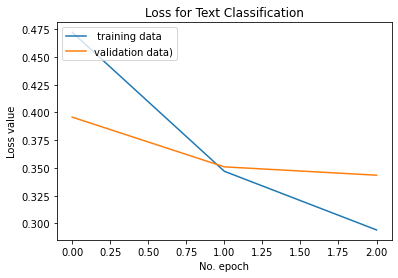

In [142]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [145]:
plt.plot(history.history['auc'], label=' (training data)')
plt.plot(history.history['val_auc'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

KeyError: 'auc'

In [147]:
import os
import sys

save_path = sys.path[0]
file_name = 'tf_cnnmodel'
modelsave = os.path.join(sys.path[0], file_name)
print(modelsave)
model.save(modelsave)

C:\Users\heilu\tf_cnnmodel
INFO:tensorflow:Assets written to: C:\Users\heilu\tf_cnnmodel\assets


In [148]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [149]:
new_model = tf.keras.models.load_model(modelsave)
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 20)           400000    
_________________________________________________________________
dense_4 (Dense)              (None, 200, 512)          10752     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 300)          461100    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1204      
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 873,056
Trainable params: 873,056
Non-trainable params: 0
________________________________________________

In [150]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer1 = pickle.load(handle)

In [151]:
df_misp_mapped['description'] = df_misp_mapped['description'].str.lower()
df_misp_mapped['description'] = df_misp_mapped['description'].apply(decontract)
df_misp_mapped['description'] = df_misp_mapped['description'].apply(cleanPunc)
df_misp_mapped['description'] = df_misp_mapped['description'].apply(keepAlpha)
df_misp_mapped['description'] = df_misp_mapped['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_misp_mapped['description'] = df_misp_mapped['description'].apply(stemming)

In [152]:
df_misp_mapped

CVE_ID Attribute_count   Industry  \
0     CVE-2009-3129              56  education   
1     CVE-2013-5065              53  education   
2     CVE-2013-3346              53  education   
3     CVE-2012-1723              53  education   
4     CVE-2013-2729              53  education   
..              ...             ...        ...   
188   CVE-2015-4902             114  utilities   
189   CVE-2014-4076             114  utilities   
190   CVE-2015-2545             142  utilities   
191   CVE-2015-2545             120  utilities   
192  CVE-2019-13720              14  utilities   

                                           description baseSeverity  \
0    microsoft offic excel sp sp sp sp offic mac op...         NULL   
1    ndproxi sys kernel microsoft window xp sp sp s...         NULL   
2    adob reader acrobat x x x allow attack execut ...         NULL   
3    unspecifi vulner java runtim environ jre compo...         NULL   
4    integ overflow adob reader acrobat x x x allow...         NULL   
..                                                 ...          ...   
188  unspecifi vulner oracl java se u u u allow rem...         NULL   
189  microsoft window server sp allow local user ga...         NULL   
190  microsoft offic sp sp sp rt sp allow remot att...         NULL   
191  microsoft offic sp sp sp rt sp allow remot att...         NULL   
192  use free webaudio googl chrome prior allow rem...         HIGH   

    MISP Severity Score misp-multiplier  Denial of Service  Buffer Overflow  \
0                     3            1.68              False            False   
1                     3            1.59              False            False   
2                     3            1.59               True            False   
3                     3            1.59              False            False   
4                     3            1.59              False            False   
..                  ...             ...                ...              ...   
188                   2            2.28              False            False   
189                   2            2.28              False            False   
190                   1            1.42              False            False   
191                   2             2.4              False            False   
192                   1            0.14              False            False   

     Code Execution  Memory Corruption  SQL Injection    XSS  \
0             False              False          False  False   
1             False              False          False  False   
2             False              False          False  False   
3             False              False          False  False   
4             False              False          False  False   
..              ...                ...            ...    ...   
188           False              False          False  False   
189           False              False          False  False   
190           False              False          False  False   
191           False              False          False  False   
192           False              False          False  False   

     Directory Traversal  Http Response Splitting  Bypass  Gain Information  \
0                  False                    False   False             False   
1                  False                    False   False             False   
2                  False                    False   False             False   
3                  False                    False   False             False   
4                  False                    False   False             False   
..                   ...                      ...     ...               ...   
188                False                    False   False             False   
189                False                    False   False             False   
190                False                    False   False             False   
191                False                    False  

In [153]:
df_notnull = df_misp_mapped.loc[df_misp_mapped['baseSeverity'] != 'NULL']
df_null = df_misp_mapped.loc[df_misp_mapped['baseSeverity'] == 'NULL']
df_null = df_null.reset_index(drop = True)
df_null

CVE_ID Attribute_count   Industry  \
0    CVE-2009-3129              56  education   
1    CVE-2013-5065              53  education   
2    CVE-2013-3346              53  education   
3    CVE-2012-1723              53  education   
4    CVE-2013-2729              53  education   
..             ...             ...        ...   
120  CVE-2015-1642             114  utilities   
121  CVE-2015-4902             114  utilities   
122  CVE-2014-4076             114  utilities   
123  CVE-2015-2545             142  utilities   
124  CVE-2015-2545             120  utilities   

                                           description baseSeverity  \
0    microsoft offic excel sp sp sp sp offic mac op...         NULL   
1    ndproxi sys kernel microsoft window xp sp sp s...         NULL   
2    adob reader acrobat x x x allow attack execut ...         NULL   
3    unspecifi vulner java runtim environ jre compo...         NULL   
4    integ overflow adob reader acrobat x x x allow...         NULL   
..                                                 ...          ...   
120  microsoft offic sp sp sp allow remot attack ex...         NULL   
121  unspecifi vulner oracl java se u u u allow rem...         NULL   
122  microsoft window server sp allow local user ga...         NULL   
123  microsoft offic sp sp sp rt sp allow remot att...         NULL   
124  microsoft offic sp sp sp rt sp allow remot att...         NULL   

    MISP Severity Score misp-multiplier  Denial of Service  Buffer Overflow  \
0                     3            1.68              False            False   
1                     3            1.59              False            False   
2                     3            1.59               True            False   
3                     3            1.59              False            False   
4                     3            1.59              False            False   
..                  ...             ...                ...              ...   
120                   2            2.28              False            False   
121                   2            2.28              False            False   
122                   2            2.28              False            False   
123                   1            1.42              False            False   
124                   2             2.4              False            False   

     Code Execution  Memory Corruption  SQL Injection    XSS  \
0             False              False          False  False   
1             False              False          False  False   
2             False              False          False  False   
3             False              False          False  False   
4             False              False          False  False   
..              ...                ...            ...    ...   
120           False              False          False  False   
121           False              False          False  False   
122           False              False          False  False   
123           False              False          False  False   
124           False              False          False  False   

     Directory Traversal  Http Response Splitting  Bypass  Gain Information  \
0                  False                    False   False             False   
1                  False                    False   False             False   
2                  False                    False   False             False   
3                  False                    False   False             False   
4                  False                    False   False             False   
..                   ...                      ...     ...               ...   
120                False                    False   False             False   
121                False                    False   False             False   
122                False                    False   False             False   
123                False                    False   False     

In [154]:
x  = np.array(tokenizer1.texts_to_sequences(df_null['description'].tolist()) )
x = pad_sequences(x, padding='post', maxlen=200)

C:\Users\heilu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [155]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all null data")
predictions = new_model.predict(x)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all null data
[[0.22461551 0.7997263  0.00290453 0.01954621]
 [0.05630499 0.8068625  0.00703579 0.09776065]
 [0.2726651  0.7975923  0.00321841 0.02248791]
 [0.2092683  0.34748772 0.02591926 0.29893368]
 [0.6252976  0.6023151  0.00426552 0.01977375]
 [0.26736438 0.39244008 0.00284424 0.14412382]
 [0.22461551 0.7997263  0.00290453 0.01954621]
 [0.05630499 0.8068625  0.00703579 0.09776065]
 [0.2726651  0.7975923  0.00321841 0.02248791]
 [0.2092683  0.34748772 0.02591926 0.29893368]
 [0.6252976  0.6023151  0.00426552 0.01977375]
 [0.26736438 0.39244008 0.00284424 0.14412382]
 [0.05630499 0.8068625  0.00703579 0.09776065]
 [0.2726651  0.7975923  0.00321841 0.02248791]
 [0.55443597 0.7577756  0.00388873 0.01028007]
 [0.55443597 0.7577756  0.00388873 0.01028007]
 [0.21076825 0.47906372 0.00779134 0.14626732]
 [0.5323437  0.7305882  0.00379923 0.0138635 ]
 [0.2642423  0.19792628 0.0438931  0.49896565]
 [0.20516652 0.807309   0.00292021 0.01956189]
 [0.55484766 0.726875

In [156]:
df_null['baseSeverity']= predict_results
df_null['baseSeverity'] = np.where((df_null.baseSeverity == 0),'CRITICAL',df_null.baseSeverity)
df_null['baseSeverity'] = np.where((df_null.baseSeverity == '1'),'HIGH',df_null.baseSeverity)
df_null['baseSeverity'] = np.where((df_null.baseSeverity == '2'),'LOW',df_null.baseSeverity)
df_null['baseSeverity'] = np.where((df_null.baseSeverity == '3'),'MEDIUM',df_null.baseSeverity)

In [157]:
df_misp_mapped = pd.concat([df_null, df_notnull], ignore_index=True)
df_misp_mapped['Severity Score'] = df_misp_mapped['baseSeverity'].map({'LOW': 1,
                                            'MEDIUM': 2,
                                            'HIGH': 3,
                                            'CRITICAL': 4})
df_misp_mapped

CVE_ID Attribute_count   Industry  \
0     CVE-2009-3129              56  education   
1     CVE-2013-5065              53  education   
2     CVE-2013-3346              53  education   
3     CVE-2012-1723              53  education   
4     CVE-2013-2729              53  education   
..              ...             ...        ...   
188   CVE-2016-7255             114  utilities   
189   CVE-2016-1019             114  utilities   
190   CVE-2016-4117             114  utilities   
191   CVE-2017-0144             114  utilities   
192  CVE-2019-13720              14  utilities   

                                           description baseSeverity  \
0    microsoft offic excel sp sp sp sp offic mac op...         HIGH   
1    ndproxi sys kernel microsoft window xp sp sp s...         HIGH   
2    adob reader acrobat x x x allow attack execut ...         HIGH   
3    unspecifi vulner java runtim environ jre compo...         HIGH   
4    integ overflow adob reader acrobat x x x allow...     CRITICAL   
..                                                 ...          ...   
188  kernelmod driver microsoft window vista sp win...         HIGH   
189  adob flash player earlier allow remot attack c...     CRITICAL   
190  adob flash player earlier allow remot attack e...     CRITICAL   
191  smbv server microsoft window vista sp window s...         HIGH   
192  use free webaudio googl chrome prior allow rem...         HIGH   

    MISP Severity Score misp-multiplier  Denial of Service  Buffer Overflow  \
0                     3            1.68              False            False   
1                     3            1.59              False            False   
2                     3            1.59               True            False   
3                     3            1.59              False            False   
4                     3            1.59              False            False   
..                  ...             ...                ...              ...   
188                   2            2.28              False            False   
189                   2            2.28               True            False   
190                   2            2.28              False            False   
191                   2            2.28              False            False   
192                   1            0.14              False            False   

     Code Execution  ...  SQL Injection    XSS  Directory Traversal  \
0             False  ...          False  False                False   
1             False  ...          False  False                False   
2             False  ...          False  False                False   
3             False  ...          False  False                False   
4             False  ...          False  False                False   
..              ...  ...            ...    ...                  ...   
188           False  ...          False  False                False   
189           False  ...          False  False                False   
190           False  ...          False  False                False   
191            True  ...          False  False                False   
192           False  ...          False  False                False   

     Http Response Splitting  Bypass  Gain Information  Gain Privilege   CSRF  \
0                      False   False             False           False  False   
1                      False   False             False            True  False   
2                      False   False             False           False  False   
3                      False   False             False           False  False   
4                      False   False             False           False  False   
..                       ...     ...               ...             ...    ...   
188                    False   False             False            True  False   
189                    False   False             False           False  False   
190                    False

In [158]:
df['misp-multiplier'] = 0
df_scoring = pd.concat([df[['CVE_ID', 'Industry', 'baseSeverity', 'Denial of Service', 'Buffer Overflow', 'Code Execution', 'Memory Corruption', 'SQL Injection', 
'XSS', 'Directory Traversal', 'Http Response Splitting', 'Bypass', 'Gain Information', 'Gain Privilege', 'CSRF', 'File Inclusion', 'Severity Score', 'misp-multiplier']], 
 df_misp_mapped[['CVE_ID', 'Industry', 'baseSeverity', 'Denial of Service', 'Buffer Overflow', 'Code Execution', 'Memory Corruption', 'SQL Injection', 
'XSS', 'Directory Traversal', 'Http Response Splitting', 'Bypass', 'Gain Information', 'Gain Privilege', 'CSRF', 'File Inclusion', 'Severity Score', 'misp-multiplier']]], 
                       ignore_index=True)
df_scoring

CVE_ID        Industry baseSeverity  Denial of Service  \
0     CVE-2022-22977  administration         HIGH              False   
1     CVE-2022-29171  administration         HIGH              False   
2     CVE-2021-25309  administration     CRITICAL              False   
3     CVE-2017-18101  administration       MEDIUM              False   
4     CVE-2020-25154  administration       MEDIUM              False   
...              ...             ...          ...                ...   
2744   CVE-2016-7255       utilities         HIGH              False   
2745   CVE-2016-1019       utilities     CRITICAL               True   
2746   CVE-2016-4117       utilities     CRITICAL              False   
2747   CVE-2017-0144       utilities         HIGH              False   
2748  CVE-2019-13720       utilities         HIGH              False   

      Buffer Overflow  Code Execution  Memory Corruption  SQL Injection  \
0               False           False              False          False   
1               False            True              False          False   
2               False           False              False          False   
3               False           False              False          False   
4               False           False              False          False   
...               ...             ...                ...            ...   
2744            False           False              False          False   
2745            False           False              False          False   
2746            False           False              False          False   
2747            False            True              False          False   
2748            False           False              False          False   

        XSS  Directory Traversal  Http Response Splitting  Bypass  \
0     False                False                    False   False   
1     False                False                    False   False   
2     False                False                    False   False   
3     False                False                    False   False   
4     False                False                    False   False   
...     ...                  ...                      ...     ...   
2744  False                False                    False   False   
2745  False                False                    False   False   
2746  False                False                    False   False   
2747  False                False                    False   False   
2748  False                False                    False   False   

      Gain Information  Gain Privilege   CSRF  File Inclusion  Severity Score  \
0                 True            True  False           False               3   
1                False            True  False           False               3   
2                False           False  False           False               4   
3                False           False  False           False               2   
4                False           False  False           False               2   
...                ...             ...    ...             ...             ...   
2744             False            True  False           False               3   
2745             False           False  False           False               4   
2746             False           False  False           False               4   
2747             False           False  False           False               3   
2748             False           False  False           False               3   

     misp-multiplier  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
2744            2.28  
2745            2.28  
2746            2.28  
2747            2.28  
2748            0.14  

[2749 rows x 18 columns]

In [159]:
def scoring(df, ind):
    df_industry = df.loc[df['Industry']== ind]
    severity_score = []
    MISP_severity_score = []
    choice_list = ['Denial of Service', 'Buffer Overflow', 'Code Execution', 'Memory Corruption', 'SQL Injection', 
'XSS', 'Directory Traversal', 'Http Response Splitting', 'Bypass', 'Gain Information', 'Gain Privilege', 'CSRF', 'File Inclusion']
    for threat in choice_list:
        df_threat = df_industry.loc[df_industry[threat] == True][[threat, 'misp-multiplier','Severity Score']]
        values = df_threat['misp-multiplier'] * df_threat['Severity Score']
        df_threat['MISP Severity Score'] = values.where(df_threat['misp-multiplier'] != 0, other=df_threat['Severity Score'])
        MISP_severity_score.append(df_threat['MISP Severity Score'].sum())
        severity_score.append(df_threat['Severity Score'].sum())
    
    scoring = pd.DataFrame()
    scoring['threatType'] = choice_list
    scoring['severityScore'] = severity_score
    scoring['MISPSeverityScore'] = MISP_severity_score
    scoring = scoring.sort_values(by=['MISPSeverityScore'], ascending=False)   
    scoring.reset_index(drop=True, inplace=True)
    return scoring


In [160]:
industrylist = ['administration', 'hospitality', 'agriculture', 'finance', 'government', 'healthcare', 'realestate', 'retail', 'tourism', 'transportation', 'telecommunication', 'manufacturing', 'utilities']

In [ ]:
#Database connection credentials
username = os.environ.get('MySQLroot')
password = os.environ.get('MySQLrootpw')
hostname = 'localhost'
dbname = 'securemation'

#Create SQLAlchemy engine to connect to mySQL db
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
                      .format(host=hostname, db=dbname, user=username, pw=password))

In [ ]:
for i in industrylist:
    print("Created MySQL table for: " + i)
    scoring(df_scoring, i).to_sql(i, engine, index=False, if_exists='replace')

In [161]:
for i in industrylist:
    print(i)
    print(scoring(df_scoring, i))

administration
                 threatType  severityScore  MISPSeverityScore
0            Gain Privilege            179                179
1         Denial of Service             75                 75
2             SQL Injection             38                 38
3                       XSS             25                 25
4                    Bypass             22                 22
5            Code Execution             19                 19
6                      CSRF             15                 15
7           Buffer Overflow              7                  7
8          Gain Information              7                  7
9       Directory Traversal              3                  3
10        Memory Corruption              0                  0
11  Http Response Splitting              0                  0
12           File Inclusion              0                  0
hospitality
                 threatType  severityScore  MISPSeverityScore
0            Gain Privilege            369 

                 threatType  severityScore  MISPSeverityScore
0         Denial of Service             16              36.48
1            Gain Privilege             15              34.20
2           Buffer Overflow              6              13.68
3            Code Execution              6              13.68
4         Memory Corruption              0               0.00
5             SQL Injection              0               0.00
6                       XSS              0               0.00
7       Directory Traversal              0               0.00
8   Http Response Splitting              0               0.00
9                    Bypass              0               0.00
10         Gain Information              0               0.00
11                     CSRF              0               0.00
12           File Inclusion              0               0.00


In [162]:
scoring(df_scoring, 'healthcare')

threatType  severityScore  MISPSeverityScore
0            Gain Privilege            424             421.48
1             SQL Injection            393             397.40
2                       XSS            121             121.00
3            Code Execution             93              93.00
4         Denial of Service             80              77.48
5                    Bypass             62              62.00
6           Buffer Overflow             31              31.00
7       Directory Traversal             17              17.00
8                      CSRF             16              16.00
9          Gain Information              5               5.00
10        Memory Corruption              0               0.00
11  Http Response Splitting              0               0.00
12           File Inclusion              0               0.00